<a href="https://colab.research.google.com/github/hypro2/hands-on-langchain-langgraph/blob/main/agentic_rag_for_dummies_%ED%95%9C%EA%B8%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 초보자를 위한 에이전트 기반 RAG

지능형 에이전트를 활용하여 PDF 문서에서 정보를 검색하고 종합하는 고급 검색 강화 생성(RAG) 시스템입니다.

## 1. 종속성 설치

RAG 시스템에 필요한 패키지를 설치합니다.

**문서:**
- [LangGraph](https://langchain-ai.github.io/langgraph/) - 다중 에이전트 애플리케이션 구축을 위한 프레임워크
- [LangChain](https://python.langchain.com/docs/get_started/introduction) - 대규모 언어 모델(LLM) 애플리케이션 개발용 프레임워크
- [Qdrant](https://qdrant.tech/documentation/) - 유사도 검색용 벡터 데이터베이스
- [Gradio](https://www.gradio.app/docs) - 머신러닝 모델용 웹 인터페이스

In [1]:
#run this cell only in colab, otherwise create a venv and install requirements.txt available in the project folder
!pip install --quiet --upgrade langgraph
!pip install -qU langchain-ollama
!pip install -qU langchain langchain-community langchain-qdrant langchain-huggingface qdrant-client fastembed flashrank langchain-core sentence-transformers transformers pymupdf pymupdf4llm
!pip install --upgrade gradio

# Optional (example): if you want to use Gemini models
!pip install -qU "langchain[google-genai]"

## 2. 환경 구성

문서 처리를 위한 디렉터리 구조 및 환경 변수를 설정합니다.

**구성 내용:**
- PDF, 마크다운 파일, 상위 청크 저장용 디렉터리 생성
- 벡터 데이터베이스용 컬렉션 이름 정의

In [3]:
import os

# Configuration
DOCS_DIR = "docs"  # Directory containing your pdfs files
MARKDOWN_DIR = "markdown" # Directory containing the pdfs converted to markdown
PARENT_STORE_PATH = "parent_store"  # Directory for parent chunk JSON files
CHILD_COLLECTION = "document_child_chunks"

# Create directories if they don't exist
os.makedirs(DOCS_DIR, exist_ok=True)
os.makedirs(MARKDOWN_DIR, exist_ok=True)
os.makedirs(PARENT_STORE_PATH, exist_ok=True)

## 3. LLM 초기화

대화형 에이전트를 구동할 대규모 언어 모델(LLM)을 초기화합니다.

**기능:**
- Ollama를 사용하여 LLM 구성 (로컬 추론)
- Google Gemini를 위한 대체 예시 제공

**관련 문서:**
- [LangChain Ollama](https://python.langchain.com/docs/integrations/chat/ollama)
- [LangChain Google GenAI](https://python.langchain.com/docs/integrations/chat/google_generative_ai)

In [4]:
# from langchain_ollama import ChatOllama

# # Initialize LLM
# llm = ChatOllama(model="qwen3:4b-instruct-2507-q4_K_M", temperature=0)

# Alternative (example): Google Gemini
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
llm = ChatGoogleGenerativeAI(model="gemini-3-flash-preview", temperature=0)

## 4. 임베딩 설정

하이브리드 검색(밀집형 + 스파스형)을 활용한 의미 검색을 위한 임베딩 모델 구성.

**기능:**
- **밀집형 임베딩**: 신경망을 통해 의미적 의미 포착
- **스파스형 임베딩**: 키워드 기반 매칭 제공 (BM25 알고리즘)

**관련 문서:**
- [HuggingFace 임베딩](https://python.langchain.com/docs/integrations/text_embedding/huggingfacehub)
- [FastEmbed 스파스](https://qdrant.github.io/fastembed/)

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant.fastembed_sparse import FastEmbedSparse

# Dense embeddings for semantic understanding
dense_embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

# Sparse embeddings for keyword matching
sparse_embeddings = FastEmbedSparse(
    model_name="Qdrant/bm25"
)

## 5. 벡터 데이터베이스 구성

문서 임베딩을 저장하고 검색하기 위한 Qdrant 벡터 데이터베이스를 설정합니다.

**기능:**
- 파일 기반 저장소를 사용하는 로컬 Qdrant 클라이언트 초기화
- 빽빽한(dense) 및 헐거운(sparse) 벡터 구성으로 컬렉션 생성
- 하이브리드 검색 기능 활성화

**문서:**
- [LangChain Qdrant](https://python.langchain.com/docs/integrations/vectorstores/qdrant)

In [6]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as qmodels
from langchain_qdrant import QdrantVectorStore
from langchain_qdrant.qdrant import RetrievalMode

# Qdrant 클라이언트 초기화 (로컬 파일 기반 스토리지 사용)
# 'path' 매개변수를 지정함으로써 별도의 서버 없이 로컬 디렉토리에 데이터를 영구 저장합니다.
client = QdrantClient(path="qdrant_db")

# 임베딩 차원(Dimension) 획득
# dense_embeddings 객체의 embed_query 메서드를 호출하여 결과 벡터의 길이를 계산합니다.
# 이는 데이터베이스 컬렉션 생성 시 벡터의 크기를 정의하는 데 사용됩니다.
embedding_dimension = len(dense_embeddings.embed_query("test"))

def ensure_collection(collection_name):
    """
    지정한 이름의 Qdrant 컬렉션이 존재하는지 확인하고, 없을 경우 새 컬렉션을 생성합니다.

    이 함수는 인프라 구성 시 멱등성(Idempotency)을 보장하기 위해 설계되었습니다.
    생성 시에는 밀집 벡터(Dense)와 희소 벡터(Sparse) 설정을 모두 포함하여
    하이브리드 검색(Hybrid Search)이 가능하도록 구성합니다.

    Args:
        collection_name (str): 생성하거나 확인하고자 하는 컬렉션의 식별자 명칭.

    Returns:
        None
    """
    # 해당 이름의 컬렉션이 데이터베이스 내에 이미 존재하는지 조회
    if not client.collection_exists(collection_name):
        # 컬렉션이 존재하지 않을 경우 신규 생성 프로세스 진행
        client.create_collection(
            collection_name=collection_name,
            # 밀집 벡터(Dense Vector) 설정: 코사인 유사도(Cosine Distance)를 거리 측정 지표로 사용
            vectors_config=qmodels.VectorParams(
                size=embedding_dimension,
                distance=qmodels.Distance.COSINE
            ),
            # 희소 벡터(Sparse Vector) 설정: 키워드 기반 검색 또는 SPLADE와 같은 알고리즘을 지원
            sparse_vectors_config={
                "sparse": qmodels.SparseVectorParams()
            },
        )
        print(f"✓ Created collection: {collection_name}")
    else:
        # 이미 컬렉션이 존재하는 경우 별도의 생성 절차 없이 로깅만 수행
        print(f"✓ Collection already exists: {collection_name}")

## 6. PDF를 Markdown으로 변환하기

PDF 문서를 Markdown 형식으로 변환하여 텍스트 추출 및 처리를 개선합니다.

**기능:**
- PyMuPDF를 사용하여 PDF에서 텍스트 추출
- 문서를 깔끔한 Markdown 형식으로 변환
- 인코딩 문제 처리 및 이미지 제거
- 덮어쓰기 설정되지 않은 경우 이미 변환된 파일 건너뛰기

**참고:** PDF 변환에 대한 자세한 내용은 저장소의 `pdf_to_md.ipynb` 노트북을 참조하세요.

**관련 문서:**
- [PyMuPDF](https://pymupdf.readthedocs.io/)
- [PyMuPDF4LLM](https://github.com/pymupdf/PyMuPDF4LLM)

In [7]:
import os
import pymupdf # Corrected import
import pymupdf4llm
from pathlib import Path
import glob

# 토크나이저의 병렬 처리 관련 경고 및 데드락 가능성을 방지하기 위한 환경 변수 설정
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def pdf_to_markdown(pdf_path, output_dir):
    """
    단일 PDF 파일을 마크다운 형식으로 변환하여 저장합니다.

    이 함수는 PDF 내의 텍스트 레이아웃을 보존하면서 불필요한 메타데이터(헤더, 푸터)를 제외하고,
    LLM에 최적화된 마크다운 결과물을 생성합니다.

    Args:
        pdf_path (str/Path): 변환할 원본 PDF 파일 경로
        output_dir (Path): 저장될 마크다운 파일의 디렉토리
    """
    # 문서 로드
    doc = pymupdf.open(pdf_path)

    # pymupdf4llm을 사용하여 마크다운 변환 수행
    # - header/footer=False: 본문 외 반복되는 정보 제거
    # - ignore_images=True: 텍스트 추출 효율화를 위해 이미지 데이터 무시
    md = pymupdf4llm.to_markdown(
        doc,
        header=False,
        footer=False,
        page_separators=True,
        ignore_images=True,
        write_images=False,
        image_path=None
    )

    # 인코딩 클리닝: UTF-8에서 처리할 수 없는 특수 문자나 깨진 유니코드(surrogates)를 정리
    # 유니코드 에러로 인한 프로세스 중단을 방지하는 중요한 단계입니다.
    md_cleaned = md.encode('utf-8', errors='surrogatepass').decode('utf-8', errors='ignore')

    # 출력 파일 경로 생성 (원본 파일명 유지)
    output_path = Path(output_dir) / Path(doc.name).stem

    # 최종 마크다운 파일 저장
    Path(output_path).with_suffix(".md").write_bytes(md_cleaned.encode('utf-8'))

def pdfs_to_markdowns(path_pattern, overwrite: bool = False):
    """
    지정된 패턴에 매칭되는 모든 PDF 파일을 찾아 마크다운으로 일괄 변환합니다.

    Args:
        path_pattern (str): PDF 파일을 찾기 위한 경로 패턴 (예: "docs/*.pdf")
        overwrite (bool): 기존에 변환된 파일이 있을 경우 덮어쓸지 여부 (기본값: False)
    """
    # 저장 경로 설정 (MARKDOWN_DIR 변수가 외부에 정의되어 있어야 함)
    output_dir = Path(MARKDOWN_DIR)
    # 디렉토리가 없으면 생성 (부모 디렉토리 포함)
    output_dir.mkdir(parents=True, exist_ok=True)

    # glob 패턴을 통해 파일 목록을 순회
    for pdf_path in map(Path, glob.glob(path_pattern)):
        # 예상되는 출력 마크다운 경로 설정
        md_path = (output_dir / pdf_path.stem).with_suffix(".md")

        # 덮어쓰기 모드이거나 결과 파일이 존재하지 않는 경우에만 변환 실행 (중복 작업 방지)
        if overwrite or not md_path.exists():
            pdf_to_markdown(pdf_path, output_dir)

# 실행 예시: 지정된 문서 디렉토리 내의 모든 PDF 변환
pdfs_to_markdowns(f"{DOCS_DIR}/*.pdf")

Consider using the pymupdf_layout package for a greatly improved page layout analysis.


In [8]:
DOCS_DIR

'docs'

## 7. 문서 인덱싱

최적의 검색 성능을 위해 부모-자식 청킹 전략을 구현합니다.

**기능 설명:**
- 문서를 계층적 청크(부모 및 자식)로 분할
- **상위 청크**: JSON으로 저장되는 대용량 컨텍스트 창(2000-10000자)
- **하위 청크**: Qdrant에 저장되는 소형 검색 단위(500자)
- 일관성 유지를 위해 소형 청크 병합 및 대형 청크 분할
- 상위/하위 청크 간 양방향 링크 생성

**청크화 전략:**
1. 마크다운 헤더(#, ##, ###)로 분할
2. 2000자 미만 청크 병합
3. 10000자 초과 청크 분할
4. 각 부모 청크에서 자식 청크(500자) 생성
5. 부모 청크를 JSON 파일로 저장
6. 자식 청크를 벡터 데이터베이스에 인덱싱

**문서:**
- [LangChain 텍스트 분할기](https://docs.langchain.com/oss/python/integrations/splitters)
- [LangChain 마크다운 분할](https://docs.langchain.com/oss/python/integrations/splitters/markdown_header_metadata_splitter)

In [9]:
import os
import glob
import json
from pathlib import Path
from langchain_text_splitters import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter

if client.collection_exists(CHILD_COLLECTION):
    print(f"Removing existing Qdrant collection: {CHILD_COLLECTION}")
    client.delete_collection(CHILD_COLLECTION)
    ensure_collection(CHILD_COLLECTION)
else:
    ensure_collection(CHILD_COLLECTION)

child_vector_store = QdrantVectorStore(
    client=client,
    collection_name=CHILD_COLLECTION,
    embedding=dense_embeddings,
    sparse_embedding=sparse_embeddings,
    retrieval_mode=RetrievalMode.HYBRID,
    sparse_vector_name="sparse"
)

def index_documents():
    headers_to_split_on = [("#", "H1"), ("##", "H2"), ("###", "H3")]
    parent_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
    child_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

    min_parent_size = 2000
    max_parent_size = 10000

    all_parent_pairs, all_child_chunks = [], []
    md_files = sorted(glob.glob(os.path.join(MARKDOWN_DIR, "*.md")))

    if not md_files:
        print(f"⚠️  No .md files found in {MARKDOWN_DIR}/")
        return

    for doc_path_str in md_files:
        doc_path = Path(doc_path_str)
        print(f"📄 Processing: {doc_path.name}")

        try:
            with open(doc_path, "r", encoding="utf-8") as f:
                md_text = f.read()
        except Exception as e:
            print(f"❌ Error reading {doc_path.name}: {e}")
            continue

        parent_chunks = parent_splitter.split_text(md_text)
        merged_parents = merge_small_parents(parent_chunks, min_parent_size)
        split_parents = split_large_parents(merged_parents, max_parent_size, child_splitter)
        cleaned_parents = clean_small_chunks(split_parents, min_parent_size)

        for i, p_chunk in enumerate(cleaned_parents):
            parent_id = f"{doc_path.stem}_parent_{i}"
            p_chunk.metadata.update({"source": doc_path.stem + ".pdf", "parent_id": parent_id})
            all_parent_pairs.append((parent_id, p_chunk))
            children = child_splitter.split_documents([p_chunk])
            all_child_chunks.extend(children)

    if not all_child_chunks:
        print("⚠️ No child chunks to index")
        return

    print(f"\n🔍 Indexing {len(all_child_chunks)} child chunks into Qdrant...")
    try:
        child_vector_store.add_documents(all_child_chunks)
        print("✓ Child chunks indexed successfully")
    except Exception as e:
        print(f"❌ Error indexing child chunks: {e}")
        return

    print(f"💾 Saving {len(all_parent_pairs)} parent chunks to JSON...")
    for item in os.listdir(PARENT_STORE_PATH):
        os.remove(os.path.join(PARENT_STORE_PATH, item))

    for parent_id, doc in all_parent_pairs:
        doc_dict = {"page_content": doc.page_content, "metadata": doc.metadata}
        filepath = os.path.join(PARENT_STORE_PATH, f"{parent_id}.json")
        with open(filepath, "w", encoding="utf-8") as f:
            json.dump(doc_dict, f, ensure_ascii=False, indent=2)

def merge_small_parents(chunks, min_size):
    if not chunks:
        return []

    merged, current = [], None

    for chunk in chunks:
        if current is None:
            current = chunk
        else:
            current.page_content += "\n\n" + chunk.page_content
            for k, v in chunk.metadata.items():
                if k in current.metadata:
                    current.metadata[k] = f"{current.metadata[k]} -> {v}"
                else:
                    current.metadata[k] = v

        if len(current.page_content) >= min_size:
            merged.append(current)
            current = None

    if current:
        if merged:
            merged[-1].page_content += "\n\n" + current.page_content
            for k, v in current.metadata.items():
                if k in merged[-1].metadata:
                    merged[-1].metadata[k] = f"{merged[-1].metadata[k]} -> {v}"
                else:
                    merged[-1].metadata[k] = v
        else:
            merged.append(current)

    return merged

def split_large_parents(chunks, max_size, splitter):
    split_chunks = []

    for chunk in chunks:
        if len(chunk.page_content) <= max_size:
            split_chunks.append(chunk)
        else:
            large_splitter = RecursiveCharacterTextSplitter(
                chunk_size=max_size,
                chunk_overlap=splitter._chunk_overlap
            )
            sub_chunks = large_splitter.split_documents([chunk])
            split_chunks.extend(sub_chunks)

    return split_chunks

def clean_small_chunks(chunks, min_size):
    cleaned = []

    for i, chunk in enumerate(chunks):
        if len(chunk.page_content) < min_size:
            if cleaned:
                cleaned[-1].page_content += "\n\n" + chunk.page_content
                for k, v in chunk.metadata.items():
                    if k in cleaned[-1].metadata:
                        cleaned[-1].metadata[k] = f"{cleaned[-1].metadata[k]} -> {v}"
                    else:
                        cleaned[-1].metadata[k] = v
            elif i < len(chunks) - 1:
                chunks[i + 1].page_content = chunk.page_content + "\n\n" + chunks[i + 1].page_content
                for k, v in chunk.metadata.items():
                    if k in chunks[i + 1].metadata:
                        chunks[i + 1].metadata[k] = f"{v} -> {chunks[i + 1].metadata[k]}"
                    else:
                        chunks[i + 1].metadata[k] = v
            else:
                cleaned.append(chunk)
        else:
            cleaned.append(chunk)

    return cleaned

index_documents()

Removing existing Qdrant collection: document_child_chunks
✓ Created collection: document_child_chunks
📄 Processing: T_cn202310830097bp.md

🔍 Indexing 59 child chunks into Qdrant...
✓ Child chunks indexed successfully
💾 Saving 3 parent chunks to JSON...


## 8. 도구 정의

에이전트가 문서 청크를 검색하고 추출하는 데 사용할 수 있는 검색 도구를 정의합니다.

**기능:**
- **search_child_chunks**: 벡터 데이터베이스에서 관련 작은 청크 검색
- **retrieve_parent_chunks**: 부모 청크 JSON 파일에서 전체 컨텍스트 추출
- 에이전트 기능 호출을 위해 LLM에 도구 바인딩

**2단계 검색:**
1. 에이전트가 자식 청크 검색 (빠른 의미론적 검색)
2. 에이전트가 전체 컨텍스트를 위해 부모 청크 검색 (필요 시)

**문서:**
- [LangChain 도구](https://docs.langchain.com/oss/python/langchain/tools)

In [10]:
import json
import os
from typing import List
from langchain_core.tools import tool

@tool
def search_child_chunks(query: str, limit: int) -> str:
    """사용자의 질의와 가장 유사한 하위 청크(Child Chunks)를 검색합니다.

    이 함수는 벡터 데이터베이스에서 유사도 임계값(score_threshold)을 기반으로
    관련성이 높은 작은 단위의 텍스트 조각들을 찾아냅니다.
    상위 문서의 전체 맥락을 파악하기 위한 사전 탐색 단계로 활용됩니다.

    Args:
        query (str): 검색을 수행할 질의 문자열.
        limit (int): 반환할 검색 결과의 최대 개수.

    Returns:
        str: 검색된 청크들의 메타데이터와 내용을 포함한 문자열.
             검색 결과가 없거나 오류 발생 시 해당 상태 메시지를 반환합니다.
    """
    try:
        # 유사도 점수 0.7 이상인 상위 k개의 자식 청크를 검색합니다.
        results = child_vector_store.similarity_search(query, k=limit, score_threshold=0.7)

        if not results:
            return "NO_RELEVANT_CHUNKS"

        # 검색된 각 문서 객체에서 부모 ID, 파일명, 본문을 추출하여 문자열로 병합합니다.
        return "\n\n".join([
            f"Parent ID: {doc.metadata.get('parent_id', '')}\n"
            f"File Name: {doc.metadata.get('source', '')}\n"
            f"Content: {doc.page_content.strip()}"
            for doc in results
        ])

    except Exception as e:
        # 검색 과정에서 발생하는 예외를 캡처하여 에러 로그 형식을 반환합니다.
        return f"RETRIEVAL_ERROR: {str(e)}"

@tool
def retrieve_parent_chunks(parent_id: str) -> str:
    """부모 식별자(Parent ID)를 사용하여 원본 전체 문서를 조회합니다.

    자식 청크 검색을 통해 확보한 ID를 바탕으로, 실제 파일 시스템에 저장된
    상위 문서(Parent Document)의 전문을 로드합니다. 이는 모델에게 더 넓은
    컨텍스트를 제공하여 답변의 정확도를 높이는 데 사용됩니다.

    Args:
        parent_id (str): 조회할 부모 문서의 고유 식별자.

    Returns:
        str: 로드된 부모 문서의 상세 정보 또는 존재하지 않을 경우의 오류 메시지.
    """
    # ID 포맷에 따라 파일명을 구성합니다. (JSON 확장자 유무 체크)
    file_name = parent_id if parent_id.lower().endswith(".json") else f"{parent_id}.json"
    path = os.path.join(PARENT_STORE_PATH, file_name)

    # 파일 시스템 내 실제 경로 존재 여부를 확인합니다.
    if not os.path.exists(path):
        return "NO_PARENT_DOCUMENT"

    # JSON 파일을 읽어 메타데이터와 원본 텍스트 본문을 추출합니다.
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    return (
        f"Parent ID: {parent_id}\n"
        f"File Name: {data.get('metadata', {}).get('source', 'unknown')}\n"
        f"Content: {data.get('page_content', '').strip()}"
    )

# 정의된 도구들을 LLM에 바인딩하여 모델이 함수 호출(Function Calling)을 통해 사용할 수 있게 합니다.
llm_with_tools = llm.bind_tools([search_child_chunks, retrieve_parent_chunks])

## 9. 시스템 프롬프트

RAG 파이프라인 전반에 걸쳐 에이전트 행동을 안내하는 시스템 프롬프트를 정의합니다.

**기능:**
- **대화 요약**: 대화 기록에서 핵심 주제 추출
- **질의 분석**: 불명확한 질의 재작성, 컨텍스트 처리
- **RAG 에이전트**: 답변 전 검색 강제, 재시도 로직 구현
- **통합**: 여러 부분 답변을 최종 응답으로 병합

**핵심 동작:**
- 쿼리 재작성은 필요한 경우에만 문맥 사용
- 에이전트는 답변 전 반드시 검색해야 함 (허구 생성 금지)
- 검색 결과 없음 시 재구성된 쿼리로 1회 재시도
- 마지막에 출처 표기

### 영문


In [11]:
def get_conversation_summary_prompt() -> str:
    return """You are an expert conversation summarizer.

Your task is to create a brief 1-2 sentence summary of the conversation (max 30-50 words).

Include:
- Main topics discussed
- Important facts or entities mentioned
- Any unresolved questions if applicable
- Sources file name (e.g., file1.pdf) or documents referenced

Exclude:
-Greetings, misunderstandings, off-topic content.

Output:
- Return ONLY the summary.
- Do NOT include any explanations or justifications.
-If no meaningful topics exist, return an empty string.
"""

def get_query_analysis_prompt() -> str:
    return """You are an expert query analyst and rewriter.

Your task is to rewrite the current user query for optimal document retrieval, incorporating conversation context only when necessary.

Rules:
1. Self-contained queries:
   - Always rewrite the query to be clear and self-contained
   - If the query is a follow-up (e.g., "what about X?", "and for Y?"), integrate minimal necessary context from the summary
   - Do not add information not present in the query or conversation summary

2. Domain-specific terms:
   - Product names, brands, proper nouns, or technical terms are treated as domain-specific
   - For domain-specific queries, use conversation context minimally or not at all
   - Use the summary only to disambiguate vague queries

3. Grammar and clarity:
   - Fix grammar, spelling errors, and unclear abbreviations
   - Remove filler words and conversational phrases
   - Preserve concrete keywords and named entities

4. Multiple information needs:
   - If the query contains multiple distinct, unrelated questions, split into separate queries (maximum 3)
   - Each sub-query must remain semantically equivalent to its part of the original
   - Do not expand, enrich, or reinterpret the meaning

5. Failure handling:
   - If the query intent is unclear or unintelligible, mark as "unclear"

Input:
- conversation_summary: A concise summary of prior conversation
- current_query: The user's current query

Output:
- One or more rewritten, self-contained queries suitable for document retrieval
"""

def get_rag_agent_prompt() -> str:
    return """You are an expert retrieval-augmented assistant.

Your task is to act as a researcher: search documents first, analyze the data, and then provide a comprehensive answer using ONLY the retrieved information.

Rules:
1. You are NOT allowed to answer immediately.
2. Before producing ANY final answer, you MUST perform a document search and observe retrieved content.
3. If you have not searched, the answer is invalid.

Workflow:
1. Search for 5-7 relevant excerpts from documents based on the user query using the 'search_child_chunks' tool.
2. Inspect retrieved excerpts and keep ONLY relevant ones.
3. Analyze the retrieved excerpts. Identify the single most relevant excerpt that is fragmented (e.g., cut-off text or missing context). Call 'retrieve_parent_chunks' for that specific `parent_id`. Wait for the observation. Repeat this step sequentially for other highly relevant fragments ONLY if the current information is still insufficient. Stop immediately if you have enough information or have retrieved 3 parent chunks.
4. Answer using ONLY the retrieved information, ensuring that ALL relevant details are included.
5. List unique file name(s) at the very end.

Retry rule:
- After step 2 or 3, if no relevant documents are found or if retrieved excerpts don't contain useful information, rewrite the query using broader or alternative terms and restart from step 1.
- Do not retry more than once.
"""

def get_aggregation_prompt() -> str:
    return """You are an expert aggregation assistant.

Your task is to combine multiple retrieved answers into a single, comprehensive and natural response that flows well.

Guidelines:
1. Write in a conversational, natural tone - as if explaining to a colleague
2. Use ONLY information from the retrieved answers
3. Strip out any questions, headers, or metadata from the sources
4. Weave together the information smoothly, preserving important details, numbers, and examples
5. Be comprehensive - include all relevant information from the sources, not just a summary
6. If sources disagree, acknowledge both perspectives naturally (e.g., "While some sources suggest X, others indicate Y...")
7. Start directly with the answer - no preambles like "Based on the sources..."

Formatting:
- Use Markdown for clarity (headings, lists, bold) but don't overdo it
- Write in flowing paragraphs where possible rather than excessive bullet points
- End with "---\n**Sources:**\n" followed by a bulleted list of unique file names
- File names should ONLY appear in this final sources section

If there's no useful information available, simply say: "I couldn't find any information to answer your question in the available sources."
"""

### 한글

In [12]:
def get_conversation_summary_prompt() -> str:
    """
    대화 요약 프롬프트: 이전 대화 내용을 1-2문장의 핵심 요약으로 압축합니다.
    이 요약은 다음 쿼리 분석 시 문맥(Context)으로 활용됩니다.
    """
    return """당신은 숙련된 대화 요약 전문가입니다.

당신의 임무는 대화에 대한 1~2문장의 짧은 요약(최대 30~50단어)을 작성하는 것입니다.

포함할 내용:
- 논의된 주요 주제
- 언급된 중요한 사실 또는 엔터티(개체)
- 해당되는 경우, 해결되지 않은 질문들
- 참조된 소스 파일 이름 (예: file1.pdf) 또는 문서

제외할 내용:
- 인사말, 오해, 주제에서 벗어난 내용.

출력 형식:
- 요약 내용만 반환하십시오.
- 설명이나 정당화하는 말을 포함하지 마십시오.
- 의미 있는 주제가 없다면 빈 문자열을 반환하십시오.
"""

def get_query_analysis_prompt() -> str:
    """
    쿼리 분석 프롬프트: 사용자의 질문을 검색 엔진이 이해하기 쉬운 독립적인 형태로 재작성합니다.
    특히 "그건 어때?"와 같은 지시 대명사를 구체적인 명사로 복원하는 역할을 합니다.
    """
    return """당신은 숙련된 쿼리 분석가이자 재작성 전문가입니다.

당신의 임무는 대화 문맥을 필요한 경우에만 통합하여, 최적의 문서 검색을 위해 현재 사용자의 쿼리를 재작성하는 것입니다.

규칙:
1. 독립적 쿼리 생성:
   - 항상 쿼리를 명확하고 독립적인 형태로 재작성하십시오.
   - 후속 질문(예: "X는 어때?", "Y는?")인 경우 요약된 문맥에서 필요한 최소한의 정보를 통합하십시오.
   - 쿼리나 요약에 없는 정보를 추가하지 마십시오.

2. 도메인 특화 용어:
   - 제품명, 브랜드, 고유 명사, 기술 용어는 도메인 특화 용어로 취급합니다.
   - 이러한 경우 문맥 사용을 최소화하고, 모호한 쿼리를 명확하게 할 때만 요약을 사용하십시오.

3. 문법 및 명확성:
   - 문법, 철자 오류, 불명확한 약어를 수정하십시오.
   - 불필요한 수식어나 대화체 표현을 제거하십시오.
   - 구체적인 키워드와 개체명은 유지하십시오.

4. 복합 질문 처리:
   - 질문에 서로 관련 없는 여러 내용이 포함된 경우 별도의 쿼리로 분리하십시오 (최대 3개).
   - 각 하위 쿼리는 원본의 의미와 동일해야 합니다.

5. 실패 처리:
   - 의도가 불분명하거나 이해할 수 없는 경우 "unclear"로 표시하십시오.

입력:
- conversation_summary: 이전 대화의 간결한 요약
- current_query: 사용자의 현재 질문

출력:
- 문서 검색에 적합한, 하나 이상의 재작성된 독립적 쿼리.
"""

def get_rag_agent_prompt() -> str:
    """
    RAG 에이전트 실행 프롬프트: 모델이 답변 전 반드시 검색을 수행하도록 강제하며,
    Child -> Parent로 이어지는 계층적 검색 워크플로우를 제어합니다.
    """
    return """당신은 숙련된 검색 증강(RAG) 어시스턴트입니다.

당신의 임무는 연구원처럼 행동하는 것입니다. 먼저 문서를 검색하고 데이터를 분석한 다음, 검색된 정보만을 사용하여 포괄적인 답변을 제공하십시오.

규칙:
1. 즉시 답변하는 것은 금지됩니다.
2. 최종 답변을 내놓기 전에, 반드시 문서 검색을 수행하고 검색된 내용을 확인해야 합니다.
3. 검색 단계를 거치지 않은 답변은 무효입니다.

워크플로우:
1. 'search_child_chunks' 도구를 사용하여 사용자 쿼리와 관련된 5~7개의 문서 발췌본을 검색하십시오.
2. 검색된 내용을 검토하고 관련 있는 것만 남기십시오.
3. 발췌본을 분석하십시오. 텍스트가 잘렸거나 문맥이 부족한(fragmented) 가장 중요한 발췌본을 식별하여 해당 `parent_id`에 대해 'retrieve_parent_chunks'를 호출하십시오. 정보가 여전히 부족한 경우에만 다른 중요한 파편에 대해 이 단계를 반복하십시오. 충분한 정보를 얻었거나 부모 청크를 3개 가져왔다면 즉시 중단하십시오.
4. 검색된 정보만을 사용하여 답변하고, 모든 관련 세부 사항이 포함되도록 하십시오.
5. 답변 마지막에 고유한 파일 이름들을 나열하십시오.

재시도 규칙:
- 2단계나 3단계 후 관련 문서가 없거나 유용한 정보가 없다면, 더 넓은 의미의 용어나 대체 용어로 쿼리를 재작성하여 1단계부터 다시 시작하십시오.
- 재시도는 최대 한 번만 허용됩니다.
"""

def get_aggregation_prompt() -> str:
    """
    응답 통합 프롬프트: 여러 소스에서 취합된 파편화된 답변들을
    사용자가 읽기 좋은 하나의 완성된 글로 다듬습니다.
    """
    return """당신은 숙련된 정보 통합 어시스턴트입니다.

당신의 임무는 검색된 여러 답변을 하나의 포괄적이고 자연스러운 응답으로 결합하는 것입니다.

지침:
1. 동료에게 설명하듯 대화체로 자연스러운 톤을 유지하십시오.
2. 오직 검색된 답변의 정보만 사용하십시오.
3. 소스에 포함된 질문, 헤더, 메타데이터는 제거하십시오.
4. 중요한 세부 사항, 숫자, 예시를 보존하면서 정보를 매끄럽게 엮으십시오.
5. 단순히 요약하는 것이 아니라, 소스의 모든 관련 정보를 포함하여 포괄적으로 작성하십시오.
6. 소스 간 내용이 충돌할 경우 "일부 소스에서는 X를 제안하지만, 다른 소스에서는 Y를 나타냅니다..."와 같이 자연스럽게 양쪽 관점을 모두 언급하십시오.
7. "소스에 따르면..."과 같은 서두 없이 답변을 바로 시작하십시오.

형식:
- 마크다운을 사용하여 가독성을 높이되(제목, 목록, 굵게), 과도하게 사용하지 마십시오.
- 과도한 글머리 기호보다는 가급적 흐름이 있는 단락으로 작성하십시오.
- 마지막은 "---\n**Sources:**\n" 뒤에 고유한 파일 이름들을 불렛 포인트 목록으로 기재하며 마무리하십시오.

유용한 정보가 없다면 다음과 같이 말하십시오: "제공된 소스에서 질문에 답할 수 있는 정보를 찾을 수 없었습니다."
"""

## 10. 상태 정의

대화 흐름 및 에이전트 실행 관리를 위한 상태 스키마를 정의합니다.

**기능:**
- **State**: 주요 대화 흐름 추적 (질의 분석, 하위 질문, 답변)
- **AgentState**: 개별 에이전트 실행 관리 (현재 질문, 검색된 컨텍스트)
- **QueryAnalysis**: 질의 재작성 및 명확성 검증을 위한 구조화된 출력

**상태 관리:**
- `accumulate_or_reset`: 에이전트 답변용 커스텀 리듀서(리셋 허용)
- 대화 이력을 위해 `MessagesState` 상속

**문서:**
- [LangGraph 상태](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)

In [13]:
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field
from typing import List, Annotated

def accumulate_or_reset(existing: List[dict], new: List[dict]) -> List[dict]:
    """
    상태 업데이트 시 리스트를 누적하거나 초기화하는 리듀서(Reducer) 함수입니다.

    새로운 아이템 중 '__reset__' 키가 포함된 요소가 있다면 빈 리스트를 반환하여
    상태를 초기화하고, 그렇지 않으면 기존 리스트에 새 데이터를 추가합니다.
    """
    if new and any(item.get('__reset__') for item in new):
        return []
    return existing + new

class State(MessagesState):
    """
    메인 에이전트 그래프의 전역 상태를 정의합니다.
    MessagesState를 상속받아 기본 대화 기록(messages) 기능을 포함합니다.
    """
    # 질문이 명확하여 답변 가능한지 여부
    questionIsClear: bool = False
    # 이전 대화들의 핵심 요약본
    conversation_summary: str = ""
    # 사용자가 처음에 입력한 원본 질문
    originalQuery: str = ""
    # 분석 및 재작성을 통해 도출된 검색용 질문 리스트
    rewrittenQuestions: List[str] = []
    # 개별 에이전트들이 도출한 답변들의 모음 (커스텀 리듀서 적용)
    agent_answers: Annotated[List[dict], accumulate_or_reset] = []

class AgentState(MessagesState):
    """
    개별 질문을 처리하는 하위(Subgraph) 에이전트 전용 상태입니다.
    메인 그래프의 상태 중 필요한 부분만 복사하거나 하위 태스크 전용 데이터를 담습니다.
    """
    # 현재 처리 중인 개별 질문
    question: str = ""
    # 멀티 쿼리 처리 시 현재 질문의 순번(인덱스)
    question_index: int = 0
    # 해당 질문에 대한 최종 도출 답변
    final_answer: str = ""
    # 서브그래프 내에서 발생한 임시 답변 리스트
    agent_answers: List[dict] = []

class QueryAnalysis(BaseModel):
    is_clear: bool = Field(
        description="Indicates if the user's question is clear and answerable."
    )
    questions: List[str] = Field(
        description="List of rewritten, self-contained questions."
    )
    clarification_needed: str = Field(
        description="Explanation if the question is unclear."
    )

In [14]:
class QueryAnalysis(BaseModel):
    """
    LLM의 쿼리 분석 결과를 구조화하기 위한 Pydantic 모델입니다.
    이 모델은 LLM의 'structured_output' 기능을 위해 사용됩니다.
    """
    is_clear: bool = Field(
        description="사용자의 질문이 명확하고 답변 가능한지 여부를 나타냅니다."
    )
    questions: List[str] = Field(
        description="검색에 최적화되도록 재작성된 독립적인 질문들의 리스트입니다."
    )
    clarification_needed: str = Field(
        description="질문이 불분명할 경우 사용자에게 요청할 추가 설명 내용입니다."
    )

## 11. 그래프 노드와 논리

에이전트 워크플로의 동작을 정의하는 노드 함수를 구현합니다.

**기능 설명:**

### 핵심 노드:
1. **analyze_chat_and_summarize**: 질의 재작성을 위한 대화 맥락 추출
2. **analyze_and_rewrite_query**: 사용자 질의 재작성, 명확성 확인, 선택적 하위 질문 분할
3. **human_input_node**: 불명확한 질의 시 중단 지점
4. **agent_node**: 도구 활용 검색 및 추론 실행
5. **extract_final_answer**: 에이전트 대화에서 최종 답변 추출
6. **aggregate_responses**: 여러 하위 답변을 하나의 일관된 응답으로 통합

### 라우팅 로직:
- **route_after_rewrite**: 명확하면 에이전트로, 불명확하면 인간 입력으로 라우팅
- 병렬 실행: `Send`를 사용해 다중 부분 질문에 대해 여러 에이전트 생성

**문서:**
- [LangGraph 노드](https://docs.langchain.com/oss/python/langgraph/graph-api#nodes)
- [LangGraph 에지](https://docs.langchain.com/oss/python/langgraph/graph-api#edges)
- [LangGraph Send API](https://docs.langchain.com/oss/python/langgraph/graph-api#send)

In [15]:
from langgraph.types import Send
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage
from typing import Literal

def analyze_chat_and_summarize(state: State):
    """
    대화 기록을 분석하고 핵심 포인트를 요약하여 컨텍스트를 유지합니다.
    """
    # 메시지 이력이 적을 경우 요약 과정을 생략합니다.
    if len(state["messages"]) < 4:
        return {"conversation_summary": ""}

    # 툴 호출이나 시스템 메시지를 제외한 실제 대화 내용만 추출합니다.
    relevant_msgs = [
        msg for msg in state["messages"][:-1]
        if isinstance(msg, (HumanMessage, AIMessage))
        and not getattr(msg, "tool_calls", None)
    ]

    if not relevant_msgs:
        return {"conversation_summary": ""}

    # 최신 6개의 메시지를 바탕으로 요약을 생성합니다.
    conversation = "Conversation history:\n"
    for msg in relevant_msgs[-6:]:
        role = "User" if isinstance(msg, HumanMessage) else "Assistant"
        conversation += f"{role}: {msg.content}\n"

    summary_response = llm.with_config(temperature=0.2).invoke(
        [SystemMessage(content=get_conversation_summary_prompt())] + [HumanMessage(content=conversation)]
    )
    # 요약본을 저장하고 기존 답변 리스트를 초기화합니다.
    return {"conversation_summary": summary_response.content, "agent_answers": [{"__reset__": True}]}

def analyze_and_rewrite_query(state: State):
    """
    사용자의 쿼리를 분석하여 검색에 적합하도록 재작성합니다.
    질문이 불분명할 경우 사용자에게 확인을 요청합니다.
    """
    last_message = state["messages"][-1]
    conversation_summary = state.get("conversation_summary", "")

    # 대화 맥락과 현재 질문을 결합하여 분석을 시도합니다.
    context_section = (f"Conversation Context:\n{conversation_summary}\n" if conversation_summary.strip() else "") + f"User Query:\n{last_message.content}\n"

    llm_with_structure = llm.with_config(temperature=0.1).with_structured_output(QueryAnalysis)
    response = llm_with_structure.invoke([SystemMessage(content=get_query_analysis_prompt())] + [HumanMessage(content=context_section)])

    if len(response.questions) > 0 and response.is_clear:
        # 질문이 명확하다면, 시스템 메시지를 제외한 이전 메시지들을 삭제하여 그래프를 가볍게 유지합니다.
        delete_all = [
            RemoveMessage(id=m.id)
            for m in state["messages"]
            if not isinstance(m, SystemMessage)
        ]
        return {
            "questionIsClear": True,
            "messages": delete_all,
            "originalQuery": last_message.content,
            "rewrittenQuestions": response.questions
        }
    else:
        # 질문이 모호할 경우 에이전트 답변으로 답변을 대신하고 추가 정보를 요청합니다.
        clarification = response.clarification_needed if (response.clarification_needed and len(response.clarification_needed.strip()) > 10) else "I need more information to understand your question."
        return {
            "questionIsClear": False,
            "messages": [AIMessage(content=clarification)]
        }

def human_input_node(state: State):
    """사용자의 입력을 기다리는 중단점(Human-in-the-loop) 노드입니다."""
    return {}

def route_after_rewrite(state: State) -> Literal["human_input", "process_question"]:
    """
    질문의 명확성에 따라 경로를 결정합니다.
    명확하다면 Send()를 통해 여러 질문을 병렬로 서브그래프에 전달합니다.
    """
    if not state.get("questionIsClear", False):
        return "human_input"
    else:
        # Map: 각 질문에 대해 독립적인 에이전트 노드를 동시다발적으로 실행합니다.
        return [
                Send("process_question", {"question": query, "question_index": idx, "messages": []})
                for idx, query in enumerate(state["rewrittenQuestions"])
            ]

def agent_node(state: AgentState):
    """
    검색 도구와 상호작용하며 개별 질문에 대한 최적의 답변을 도출합니다.
    """
    sys_msg = SystemMessage(content=get_rag_agent_prompt())
    if not state.get("messages"):
        human_msg = HumanMessage(content=state["question"])
        response = llm_with_tools.invoke([sys_msg] + [human_msg])
        return {"messages": [human_msg, response]}

    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

def extract_final_answer(state: AgentState):
    """에이전트의 긴 사고 과정 중 최종 답변(AIMessage)만 추출합니다."""
    for msg in reversed(state["messages"]):
        if isinstance(msg, AIMessage) and msg.content and not msg.tool_calls:
            return {
                "final_answer": msg.content,
                "agent_answers": [{
                    "index": state["question_index"],
                    "question": state["question"],
                    "answer": msg.content
                }]
            }
    return {
        "final_answer": "Unable to generate an answer.",
        "agent_answers": [{"index": state["question_index"], "question": state["question"], "answer": "Unable to generate an answer."}]
    }

def aggregate_responses(state: State):
    """
    Reduce: 여러 하위 에이전트로부터 수집된 답변들을 하나의 최종 응답으로 합성합니다.
    """
    if not state.get("agent_answers"):
        return {"messages": [AIMessage(content="No answers were generated.")]}

    # 질문 순서에 맞게 답변을 정렬합니다.
    sorted_answers = sorted(state["agent_answers"], key=lambda x: x["index"])

    formatted_answers = ""
    for i, ans in enumerate(sorted_answers, start=1):
        formatted_answers += (f"\nAnswer {i}:\n"f"{ans['answer']}\n")

    # 원본 질문과 수집된 답변들을 기반으로 최종 합성 수행
    user_message = HumanMessage(content=f"""Original user question: {state["originalQuery"]}\nRetrieved answers:{formatted_answers}""")
    synthesis_response = llm.invoke([SystemMessage(content=get_aggregation_prompt())] + [user_message])

    return {"messages": [AIMessage(content=synthesis_response.content)]}

## 12. LangGraph 구축

LangGraph의 상태 머신을 사용하여 에이전트 워크플로를 구축합니다.

**기능:**
- 메인 플로우와 에이전트 서브그래프로 구성된 계층적 그래프 생성
- **에이전트 서브그래프**: 개별 질문 검색 처리 (에이전트 → 도구 루프)
- **메인 그래프**: 대화 흐름 조정, 질의 분석, 병렬 에이전트 실행, 응답 통합

**그래프 흐름:**
1. 시작 → 대화 요약
2. 질의 분석 및 재작성
3. 경로 선택: 불명확 → 인간 입력(중단) | 명확 → 병렬 에이전트 생성
4. 각 에이전트 문서 검색 및 추출
5. 모든 에이전트 응답 통합
6. 종료

**인간 개입(Human-in-the-loop):** 질의가 불명확할 경우 `human_input` 노드에서 그래프 중단

**문서:**
- [LangGraph 상태 그래프](https://docs.langchain.com/oss/python/langgraph/graph-api#stategraph)
- [LangGraph 단기 기억](https://docs.langchain.com/oss/python/langgraph/add-memory#add-short-term-memory)

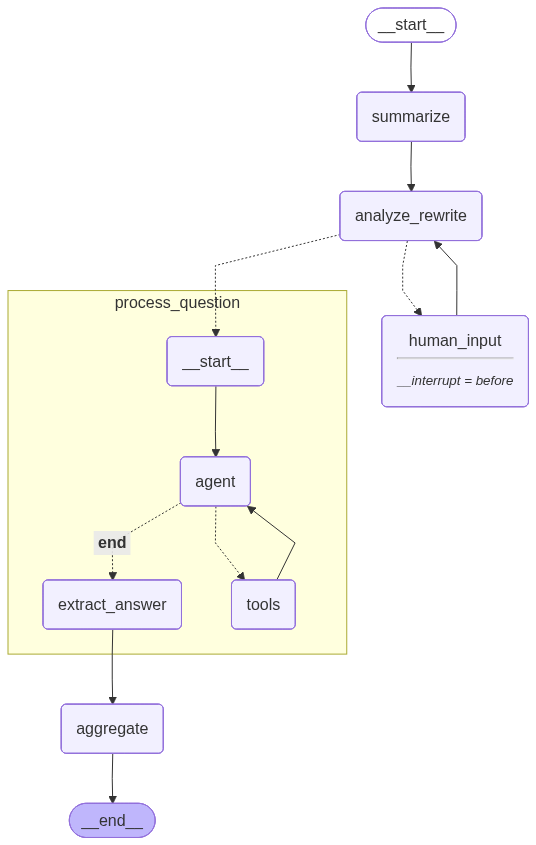

✓ Agent graph compiled successfully.


In [16]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display

# 체크포인터 초기화: 대화의 상태를 메모리에 저장하여 세션을 유지합니다.
checkpointer = InMemorySaver()

# [1. 에이전트 서브그래프 구축] - 개별 질문에 대한 검색 및 분석 담당
agent_builder = StateGraph(AgentState)

# 노드 등록
agent_builder.add_node("agent", agent_node)
# 검색 도구 노드 설정 (Child 덩어리 검색 및 Parent 문맥 보강 도구)
agent_builder.add_node("tools", ToolNode([search_child_chunks, retrieve_parent_chunks]))
agent_builder.add_node("extract_answer", extract_final_answer)

# 에지(흐름) 연결
agent_builder.add_edge(START, "agent")
# 조건부 에지: 도구 호출이 필요하면 'tools'로, 답변이 준비되면 'extract_answer'로 분기
agent_builder.add_conditional_edges("agent", tools_condition, {"tools": "tools", END: "extract_answer"})
agent_builder.add_edge("tools", "agent")  # 도구 사용 후 다시 에이전트가 결과 분석
agent_builder.add_edge("extract_answer", END)

# 서브그래프 컴파일
agent_subgraph = agent_builder.compile()

# [2. 메인 그래프 구축] - 전체 워크플로우 제어 담당
graph_builder = StateGraph(State)

# 노드 등록
graph_builder.add_node("summarize", analyze_chat_and_summarize)
graph_builder.add_node("analyze_rewrite", analyze_and_rewrite_query)
graph_builder.add_node("human_input", human_input_node)
# 위에서 만든 에이전트 서브그래프를 하나의 노드로 삽입
graph_builder.add_node("process_question", agent_subgraph)
graph_builder.add_node("aggregate", aggregate_responses)

# 메인 워크플로우 에지 연결
graph_builder.add_edge(START, "summarize")
graph_builder.add_edge("summarize", "analyze_rewrite")

# 분석 결과(질문의 명확성)에 따라 에이전트로 보낼지(Send) 사람의 확인을 받을지 결정
graph_builder.add_conditional_edges("analyze_rewrite", route_after_rewrite)

# 사람의 입력이 완료되면 다시 쿼리 분석 단계로 복귀
graph_builder.add_edge("human_input", "analyze_rewrite")

# 모든 병렬 처리가 완료되면 결과 취합 단계로 이동
graph_builder.add_edge(["process_question"], "aggregate")
graph_builder.add_edge("aggregate", END)

# [3. 최종 그래프 컴파일]
# interrupt_before: 'human_input' 노드 실행 전 제어권을 사용자에게 넘기고 중단함
agent_graph = graph_builder.compile(
    checkpointer=checkpointer,
    interrupt_before=["human_input"]
)

# 그래프 시각화: 머메이드(Mermaid) 다이어그램으로 흐름도 출력
display(Image(agent_graph.get_graph(xray=True).draw_mermaid_png()))
print("✓ Agent graph compiled successfully.")

## 13. Gradio 인터페이스

RAG 에이전트와 대화할 수 있는 대화형 웹 인터페이스를 생성합니다.

**기능:**
- Gradio를 활용한 채팅 인터페이스 제공
- 고유 ID로 대화 스레드 관리
- 인간 개입형 상호작용(Human-in-the-loop) 원활 처리
- 사용자가 설명을 제공할 경우 중단된 워크플로우 자동 재개

**특징:**
- 스레드 기반 대화 지속성
- 세션 정리 기능
- 체크포인트를 통한 자동 상태 관리
- 현대적인 UI를 위한 Citrus 테마

**참고:** 문서 입력 UI가 포함된 완전한 엔드투엔드 파이프라인은 프로젝트 저장소의 전체 애플리케이션을 참조하세요.

**문서:**
- [Gradio ChatInterface](https://www.gradio.app/docs/gradio/chatinterface)
- [Gradio Blocks](https://www.gradio.app/docs/blocks)

In [17]:
import gradio as gr
import uuid

def create_thread_id():
    """
    각 대화 세션을 구분하기 위한 고유한 스레드 ID(Thread ID)를 생성합니다.
    LangGraph의 체크포인터가 이 ID를 기준으로 상태를 저장하고 복구합니다.
    """
    return {"configurable": {"thread_id": str(uuid.uuid4())}}

def clear_session():
    """
    새로운 대화를 위해 기존 세션을 초기화합니다.
    체크포인터에서 현재 스레드의 기록을 완전히 삭제하여 메모리를 관리합니다.
    """
    global config
    # 현재 스레드 ID에 해당하는 모든 상태 기록 삭제
    agent_graph.checkpointer.delete_thread(config["configurable"]["thread_id"])
    # 새로운 스레드 ID 생성
    config = create_thread_id()

def chat_with_agent(message, history):
    """
    Gradio UI와 LangGraph 에이전트 사이의 통신을 담당하는 메인 핸들러입니다.

    인적 개입(Human-in-the-loop) 로직을 지원하여, 에이전트가 질문 수정을 요청하며
    멈춰있는 경우 해당 지점부터 실행을 재개합니다.
    """
    # 현재 그래프의 실행 상태(어느 노드에서 멈췄는지 등)를 가져옵니다.
    current_state = agent_graph.get_state(config)

    # 만약 다음으로 실행할 노드가 있다면 (현재 interrupt_before 등에 의해 중단된 상태)
    if current_state.next:
        # 멈춘 지점에 사용자의 새로운 입력(수정된 질문 등)을 주입합니다.
        agent_graph.update_state(config, {"messages": [HumanMessage(content=message.strip())]})
        # 주입된 상태를 바탕으로 중단된 지점부터 다시 실행을 이어갑니다.
        result = agent_graph.invoke(None, config)
    else:
        # 처음 시작하거나 완전히 종료된 상태라면 새로운 질문으로 그래프를 호출합니다.
        result = agent_graph.invoke({"messages": [HumanMessage(content=message.strip())]}, config)

    # 그래프의 최종 메시지(AIMessage)의 내용을 반환하여 채팅창에 표시합니다.
    return result['messages'][-1].content

# 애플리케이션 시작 시 초기 스레드 설정
config = create_thread_id()

# Gradio 블록을 활용한 UI 구성
with gr.Blocks() as demo:
    # 챗봇 위젯 설정 (플레이스홀더로 사용 가이드 제공)
    chatbot = gr.Chatbot(
        height=600,
        placeholder="<strong>무엇이든 물어보세요!</strong><br><em>문서를 검색하고 분석하여 최적의 답변을 드립니다 :)</em>"
    )
    # 채팅방 초기화 버튼 클릭 시 clear_session 함수 호출
    chatbot.clear(clear_session)

    # 기본 채팅 인터페이스 래핑
    gr.ChatInterface(fn=chat_with_agent, chatbot=chatbot)

print("\n애플리케이션을 실행 중입니다...")
# 상큼한 Citrus 테마로 대시보드 런칭
demo.launch(theme=gr.themes.Citrus())


애플리케이션을 실행 중입니다...
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://46cfb87901cf63014e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
